Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan 

https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center

Plan

EDA

BUILD
- Decide how do we want to evaluate our results --> accuracy, logloss, roc_auc
- Try to build a flexible combined pipeline for both text and numerical data

MODEL SELECTION
- Try models you have learned about
    * Logistic Regression
    * Knn
    * Bagging and random forest
    * Adaboost, Gradient boost, Stochastic gradient boosting

MODEL TUNING
- Select 2-3 best ones and proceed with hyperparamter tuning for each

EVALUATE RESULTS
- Summarize tradeoffs and implications of the models
- Why does it suit our data? What to be aware in the future if we are still going to use this model with new data

EXPLAIN
- Write a nice notebook and tell a story!

# EDA

In [99]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
# read csv and rename columns
df = pd.read_csv('transfusion.data', skiprows= 1, names=["Time since last donation (months)",
                                            "Donation count (times)",
                                            "Volume donated (cc)",
                                            "Time since first donation (months)",
                                            "Donated on March 2007"])
df.head()

,Time since last donation (months),Donation count (times),Volume donated (cc),Time since first donation (months),Donated on March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## Features
- "Time since last donation (months)"
- "Donation count (times)",
- "Volume donated (cc)",
- "Time since first donation (months)"

## Target variable
- "Donated on March 2007"

In [101]:
df.info()
# no nulls very nice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Time since last donation (months)   748 non-null    int64
 1   Donation count (times)              748 non-null    int64
 2   Volume donated (cc)                 748 non-null    int64
 3   Time since first donation (months)  748 non-null    int64
 4   Donated on March 2007               748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [102]:
# separate features and target
FEATURES = ["Time since last donation (months)",
            "Donation count (times)",
            "Volume donated (cc)",
            "Time since first donation (months)"]
X = df[FEATURES]

# convert outcome to category
df["Donated on March 2007"] = df["Donated on March 2007"].astype('category')
y= df["Donated on March 2007"]

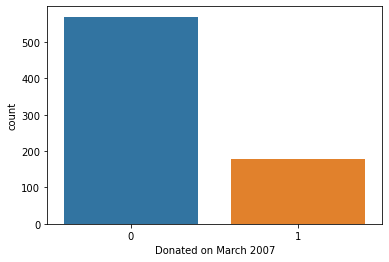

In [106]:
# look at total outcome
sns.countplot(data=df, x=df["Donated on March 2007"])
plt.show()

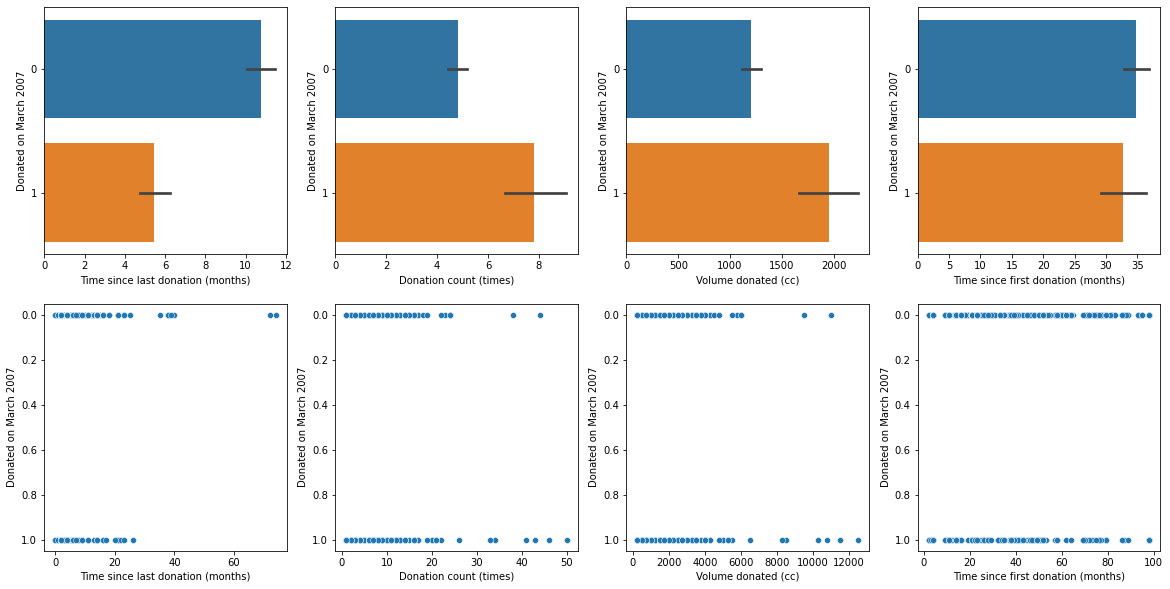

In [108]:
# look at the outcome for each feature
fig, ax = plt.subplots(2,4, figsize=(20,10))
for i in range(len(FEATURES)):
    sns.barplot(ax=ax[0][i], data=df, x=FEATURES[i], y="Donated on March 2007")
    sns.scatterplot(ax=ax[1][i], data=df, x=FEATURES[i], y="Donated on March 2007")
plt.show()

Time since last donation (months)
[<AxesSubplot:> <AxesSubplot:>]


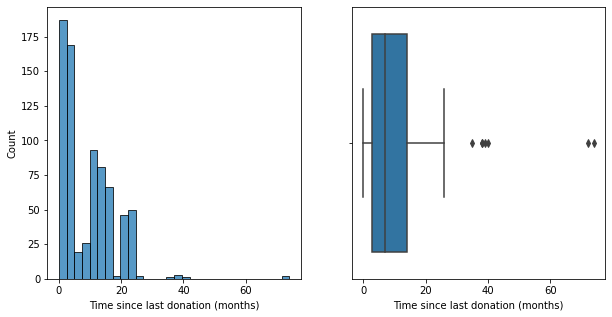

Donation count (times)
[<AxesSubplot:> <AxesSubplot:>]


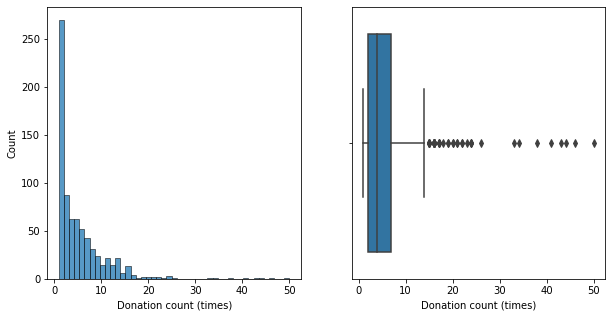

Volume donated (cc)
[<AxesSubplot:> <AxesSubplot:>]


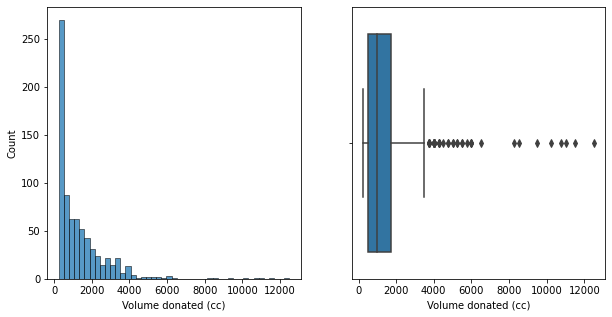

Time since first donation (months)
[<AxesSubplot:> <AxesSubplot:>]


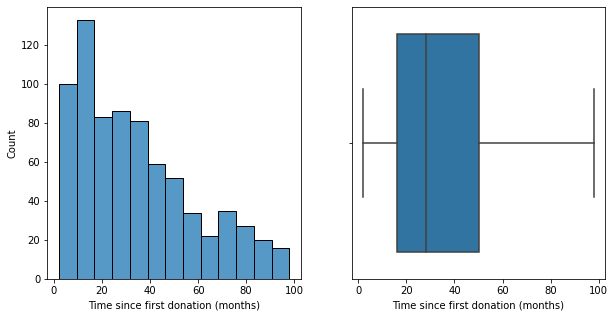

In [111]:
# look at the distributions of features
for f in FEATURES:
    print(f)
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    print(ax)
    sns.histplot(x=X[f], ax=ax[0])
    sns.boxplot(x=X[f], ax=ax[1])
    plt.show()

# features' scales are different we need to scale them
# features are rougly exponentially distributed

# Build

In [112]:
# split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=69)

In [113]:
# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# pipeline
from sklearn.pipeline import make_pipeline

pl = make_pipeline(
                    Normalizer(),
                    LogisticRegression()
                    )

# fit model
pl.fit(X_train, y_train)

Pipeline(steps=[('normalizer', Normalizer()),
                ('logisticregression', LogisticRegression())])

In [114]:
# metrics
from sklearn.metrics import accuracy_score, log_loss, classification_report

y_pred = pl.predict(X_test)
y_pred_proba = pl.predict_proba(X_test)

# accuracy_score
print('Accuracy = {}, Logloss = {}'.format(accuracy_score(y_test, y_pred), log_loss(y_test, y_pred)))

Accuracy = 0.7626112759643917, Logloss = 8.199116058139035


Logistic regression
* Plain - Accuracy = 0.7848664688427299, Logloss = 7.43047028192254
* With MinMaxScaler - Accuracy = 0.7626112759643917, Logloss = 8.199116058139035
* With StandardScaler - Accuracy = 0.771513353115727, Logloss = 7.89166581480752 (because our features are not normally distributed)
* With Normalizer - Accuracy = 0.7626112759643917, Logloss = 8.199116058139035

KNN
* Plain - Accuracy = 0.744807121661721, Logloss = 8.81409128462121
* With MinMaxScaler - Accuracy = 0.701780415430267, Logloss = 10.300253437285381
* With StandardScaler - Accuracy = 0.7047477744807121, Logloss = 10.19776211386597
* With Normalizer - Accuracy = 0.7759643916913946, Logloss = 7.737963233722137